In [1]:
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

In [2]:
def custom_region(image):
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [3]:
def custom_hough(image):
    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_length = 20
    max_line_gap = 500
    return cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

In [4]:
def calculate_slope_intercept(lines):
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(length)
    
    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [5]:
def calculate_pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [6]:
def detect_lane_lines(image, lines):
    left_lane, right_lane = calculate_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = int(y1 * 0.6)
    left_line = calculate_pixel_points(y1, y2, left_lane)
    right_line = calculate_pixel_points(y1, y2, right_lane)
    return left_line, right_line

In [7]:
def draw_detected_lines(image, lines, color=[255, 0, 0], thickness=12):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

In [8]:
def process_frame(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur, low_threshold, high_threshold)
    region = custom_region(edges)
    hough = custom_hough(region)
    result = draw_detected_lines(image, detect_lane_lines(image, hough))
    return result

In [9]:
def process_video(input_video, output_video):
    input_clip = VideoFileClip(input_video, audio=False)
    processed_clip = input_clip.fl_image(process_frame)
    processed_clip.write_videofile(output_video, audio=False)

In [17]:
def hough_transform(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    low_t = 50
    high_t = 150
    edges = cv2.Canny(blur, low_t, high_t)
    region = custom_region(edges)
    
    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_length = 20
    max_line_gap = 500
    lines = cv2.HoughLinesP(region, rho=rho, theta=theta, threshold=threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    line_image = np.zeros_like(image)
    left_lane, right_lane = calculate_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = int(y1 * 0.6)
    left_line = calculate_pixel_points(y1, y2, left_lane)
    right_line = calculate_pixel_points(y1, y2, right_lane)
    
    if left_line is not None:
        cv2.line(line_image, left_line[0], left_line[1], (255, 0, 0), 12)
    if right_line is not None:
        cv2.line(line_image, right_line[0], right_line[1], (255, 0, 0), 12)
    
    result = cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
    return result

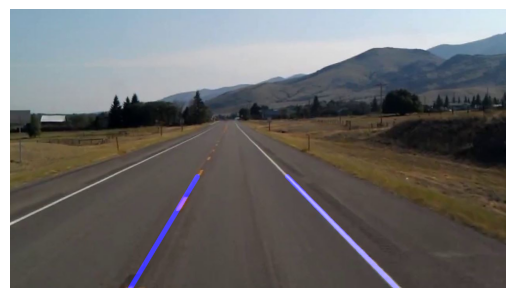

In [18]:
image_path = 'p1.jpg'
image = cv2.imread(image_path)
processed_image = hough_transform(image)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

In [11]:
process_video('test_video.mp4', 'output.mp4')

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [12]:
cap = cv2.VideoCapture('output.mp4')

try:
    cv2.namedWindow('Processed Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Processed Video', 600, 400)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Processed Video', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()